#Kaggle Bikesharing Regression Modeling Using Sci-Kit Learn
Note, the example uses an [ensemble-type](http://en.wikipedia.org/wiki/Ensemble_learning) regressor, Extra Trees Regressor, which "fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting." This technique is referred to as [bootstrap aggregating](http://en.wikipedia.org/wiki/Bootstrap_aggregating), or "bagging".

See the flow chart below for generally what sci-kit learn components to use when, and for an idea about what other models might apply:

<img src="http://scikit-learn.org/stable/_static/ml_map.png" alt="flowchart" style="width: 800px;"/>

---
#Setup: Initial Imports of Data Manipulation and Plotting Packages

Easiest way to get started:
1. Install [anaconda](https://store.continuum.io/cshop/anaconda/)
2. Go to command line, navigate to folder with existing notebook, then type `ipython notebook`

See the following links for examples or more info:
* [pandas](http://pandas.pydata.org/pandas-docs/stable/10min.html)
* [scikit-learn](http://scikit-learn.org/stable/index.html)
* [matplotlib](http://matplotlib.org/gallery.html)
* [seaborn](http://stanford.edu/~mwaskom/software/seaborn/examples/index.html)

In [1]:
# make sure all plots are output to notebook
%matplotlib inline

In [2]:
# dataframes and series (i.e., tables and columns)
import pandas as pd

# equivalent to matlab + stats toolbox
import scipy as scipy

# a fantastic statistics plotting utility, built around matplotlib (far beyond the baseline matlab plotting capability)
import seaborn as sns

# configure output to notebook for figures
sns.set_style("darkgrid")
sns.mpl.rcParams['figure.figsize'] = (16, 10)

In [3]:
# machine learning packages

# cross validation is for robust model creation/evaluation
from sklearn.cross_validation import cross_val_score

# ensemble models are typically more robust to overfitting
from sklearn.ensemble import ExtraTreesRegressor

---
#Part1: Transforming Data, Training Model, and Evaluating Model Fit

##Load the Training Data in Pandas DataFrame

In [4]:
train = pd.read_csv('./train.csv')
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1


## Define Some Helper Functions for Preparing Data

In [5]:
from datetime import datetime

def split_train_target(df):
    """Splits the df into the features and target columns."""
    
    X = df.ix[:, :-3]    # all columns up to, but not including the last three
    Y = df.ix[:, -3:]     # only the last three columns
    return X, Y

def prepare_data(df):
    """Splits the datetime information across multiple numerical feature columns."""
    
    fmt = "%Y-%m-%d %H:%M:%S"
    
    # applies the temporary function to convert to datetime to the datetime column of each row
    times = df.apply(lambda row: datetime.strptime(row['datetime'], fmt), axis=1)

    df['hour'] = times.dt.hour
    df['month'] = times.dt.month
    df['day'] = times.dt.dayofweek
    df['year'] = times.dt.year
    
    return df.ix[:, 1:]

## Apply Transforms on Training Data

In [6]:
X, Y = split_train_target(train)

X = prepare_data(X)
X.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,month,day,year
0,1,0,0,1,9.84,14.395,81,0,0,1,5,2011
1,1,0,0,1,9.02,13.635,80,0,1,1,5,2011
2,1,0,0,1,9.02,13.635,80,0,2,1,5,2011
3,1,0,0,1,9.84,14.395,75,0,3,1,5,2011
4,1,0,0,1,9.84,14.395,75,0,4,1,5,2011


In [7]:
Y.head()

,casual,registered,count
0,3,13,16
1,8,32,40
2,5,27,32
3,3,10,13
4,0,1,1


## Create the Model, Fit it to Target Data

In [8]:
# initialize the model
regressor = ExtraTreesRegressor(n_estimators=100, random_state=0, max_depth=None, min_samples_split=3, n_jobs=-1)

# robust cross-validated model scoring (not currently used)
scores = cross_val_score(regressor, X, Y, cv=10)

# fit feature data to count data
regressor.fit(X, Y['count'])

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=3, min_weight_fraction_leaf=0.0,
          n_estimators=100, n_jobs=-1, oob_score=False, random_state=0,
          verbose=0, warm_start=False)

## Evaluate Fit to Training Data

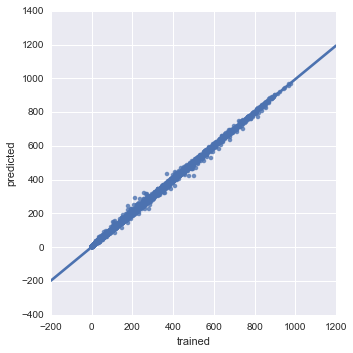

In [9]:
# predict the same counts we trained on (perfect fit not necessarily good), but shouldn't be horrible
y0 = regressor.predict(X)

# plot Trained versus Predicted
df = pd.DataFrame({'trained' : Y['count'], 'predicted' : y0})

# use seaborn to plot the predicted against the trained baseline
sns.lmplot("trained", "predicted", df)

##Other Tools are Available to Help Evaluate Fit

In [10]:
# another method to evaluate fit
slope, intercept, r_value1, p_value, std_err = scipy.stats.linregress(Y['count'], y0)
r_value1

0.99957176216154553

---
#Part2: Use Trained Model to Predict Counts on Test Data

###Load and Apply Data Transforms

In [11]:
submission = pd.read_csv('./test.csv')

# no need to split, since there is no count info
X0 = prepare_data(submission)
X0.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,month,day,year
0,1,0,1,1,10.66,11.365,56,26.0027,0,1,3,2011
1,1,0,1,1,10.66,13.635,56,0.0000,1,1,3,2011
2,1,0,1,1,10.66,13.635,56,0.0000,2,1,3,2011
3,1,0,1,1,10.66,12.880,56,11.0014,3,1,3,2011
4,1,0,1,1,10.66,12.880,56,11.0014,4,1,3,2011


###Predict New Values and Save as Submission

In [12]:
Y0 = regressor.predict(X0)

# get only the datetime series
dates = submission['datetime']

# create new dataframe, one column for counts, where the index are the dates associated with each row
submission = pd.DataFrame({'count': Y0}, index=dates)

# save out submission to csv file, ready to upload to kaggle
submission.to_csv("./my_submission.csv")